<a href="https://colab.research.google.com/github/DoubleCyclone/CNN-From-Scratch/blob/main/notebooks/CNN_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I will build a **Convolutional Neural Network Model** with **NumPy** and train it on the [CIFAR-10 dataset](https://www.kaggle.com/c/cifar-10/). Hoping to achieve a test accuracy of 70%.

# 1 - Setup and Data Acquisition
I will start this menacing task by importing the packages required as usual.

In [365]:
from torchvision import datasets
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

After the package imports, the first thing I have to do is load the dataset. I will also split the training data into Training and Validation sets so that while training the model we can use the Validation set for a more accurate metrics summary of the model. I know that the dataset has 50000 training and 10000 test samples so I will divide it to 40000 training, 10000 validation and 10000 test samples instead.

In [366]:
# Load the train and test datasets
dataset_full = datasets.CIFAR10(root="data", train=True, download=True)
dataset_test = datasets.CIFAR10(root="data", train=False, download=True)

# Split the training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(dataset_full.data, dataset_full.targets, test_size=0.2, stratify=dataset_full.targets, random_state=42)
X_test = dataset_test.data
y_test = dataset_test.targets

print(f"Training data : {X_train.shape}, labels : {len(y_train)}")
print(f"Validation data : {X_val.shape}, labels : {len(y_val)}")
print(f"Test data : {X_test.shape}, labels : {len(y_test)}")
print(f"Classes : {dataset_full.classes}, count {len(dataset_full.classes)}")

Training data : (40000, 32, 32, 3), labels : 40000
Validation data : (10000, 32, 32, 3), labels : 10000
Test data : (10000, 32, 32, 3), labels : 10000
Classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], count 10


One sample's shape is 32x32x3 which represents the size of the image and the channels in that image. Channel count being 3 here means that the image is composed of Red, Green and Blue values on top of each other (RGB). If it was comprised of a single channel, that would have meant that the image was monochromatic. (Like in the [MNIST Digit Classification dataset](https://www.kaggle.com/code/hojjatk/read-mnist-dataset)). Also, there are 10 classes in the dataset comprised of some animal species and vehicles.

Let's visualize a few images to get an idea about how they look.

In [367]:
def visualize_random(X, size, amount) :
  # Pick random indexes
  rng = np.random.default_rng()
  random_idx = rng.choice(len(X), size=amount, replace=False)

  plt.figure(figsize=(amount * 3, 2.5)) # Adjust figure size for better visualization
  for j, i in enumerate(random_idx) :
    # Resize image using LANCZOS filter for high-quality upscaling
    img = Image.fromarray(X[i]).resize((size, size), resample=Image.Resampling.LANCZOS)
    plt.subplot(1, amount, j + 1)
    plt.imshow(img)
    plt.title(f"Index: {i}, Label : {dataset_full.classes[y_train[i]]}") # Set the index and class as the title
    plt.axis('off') # Hide axes for cleaner image display
  plt.tight_layout() # Adjust subplot parameters for a tight layout
  plt.show() # Display the plot

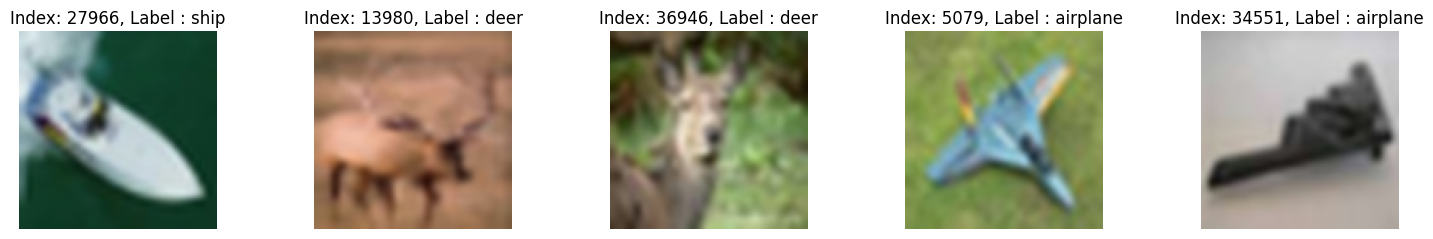

In [368]:
visualize_random(X_train, 128, 5)

As the images are really small originally, upscaling them leads to low res visualizations but they are still understandable.

We use CNNs instead of NNs for image classifications because they keep information about the pixels' neighbors as well as the pixels themselves, learning about patterns by themselves.

For my simple model, I will have the architecture built like ```Conv(32 filters) -> MaxPooling -> Conv(64 filters) -> MaxPooling -> Dense(128) -> Dense(10)``` and I will use filters of size 3x3 with no stride or padding.

# 2 - Building CNN Mathematical Components
At first, I need to scale the data from the range 0-255 to a smaller range like 0-1 to avoid the gradient explosion problem.


In [369]:
def scaledown(data) :
  return data / 255.0

In [370]:
test_images = scaledown(X_train[:10])
print(test_images.shape)
print(test_images[0])

(10, 32, 32, 3)
[[[0.21960784 0.19607843 0.16470588]
  [0.23137255 0.2        0.16078431]
  [0.2745098  0.25490196 0.2       ]
  ...
  [0.54117647 0.60392157 0.58039216]
  [0.56078431 0.61960784 0.6       ]
  [0.61568627 0.65882353 0.64705882]]

 [[0.21568627 0.19607843 0.14901961]
  [0.24705882 0.22745098 0.18431373]
  [0.31764706 0.30196078 0.25490196]
  ...
  [0.52941176 0.58431373 0.55686275]
  [0.67058824 0.73333333 0.71764706]
  [0.63921569 0.69411765 0.69411765]]

 [[0.25098039 0.24313725 0.18431373]
  [0.31372549 0.29803922 0.2627451 ]
  [0.31764706 0.30588235 0.27058824]
  ...
  [0.64705882 0.70196078 0.66666667]
  [0.76078431 0.82745098 0.81176471]
  [0.57254902 0.62352941 0.63529412]]

 ...

 [[0.17647059 0.16078431 0.13333333]
  [0.19607843 0.18039216 0.14509804]
  [0.2627451  0.24705882 0.20392157]
  ...
  [0.52941176 0.52941176 0.44313725]
  [0.44313725 0.44313725 0.35686275]
  [0.50196078 0.49803922 0.41568627]]

 [[0.18431373 0.17647059 0.14117647]
  [0.18431373 0.17647

After the scaling I need to convert the images from 3 dimensional arrays to 2 dimensional arrays by getting rid of the channel dimension and just concatenating the channels together in such a way that every column represents all the information gathered from one position from the sliding window technique (1 column = kernel size x channel size amount of data). This approach is called **im2col**.

In [371]:
def im2col(images, kernels) :
  kernel_c, kernel_h, kernel_w = kernels[0].shape  # Get kernel dimensions (e.g., 3 x 3 x 3)
  permuted = np.transpose(images, (0, 3, 1, 2)) # From BxHxWxC to BxCxHxW
  B, C, H, W = permuted.shape # Get all dimensions for the image (e.g., 10 x 3 x 32 x 32)

  output_h = H - kernel_h + 1 # Output height (e.g., 30)
  output_w = W - kernel_w + 1 # Output width (e.g., 30)

  # The number of patches for each image
  num_patches = output_h * output_w # (e.g., 900)
  # The size of each flattened patch (channels * kernel_height * kernel_width)
  patch_size = C * kernel_h * kernel_w # (e.g., 3 * 3 * 3 = 27)

  # Initialize the output array with shape (Batch_size, patch_size, num_patches)
  output = np.empty((B, patch_size, num_patches))

  for b_idx in range(B): # Iterate through each image in the batch
    patch_count = 0
    for i in range(output_h): # Iterate through the height of the output feature map
      for j in range(output_w): # Iterate through the width of the output feature map
        # Extract the current patch and flatten it
        patch = permuted[b_idx, :, i:i+kernel_h, j:j+kernel_w].flatten()
        # Assign the flattened patch as a column vector in the output array
        output[b_idx, :, patch_count] = patch
        patch_count += 1
  return output

In [372]:
test_kernels = np.ones(shape=(2, 3, 3, 3))
test_images_col = im2col(test_images, test_kernels)

Now that our manual implementation of the **im2col** function is working, I need to implement the convolution function. Meaning calculating the dot product between different parts of the image with kernels and reducing the size of the image while keeping pattern information. While initializing the kernels, I will be using the **Kaiming (He)** Initialization which works well with **ReLU** activation function which I will use after the convolution processes. Also, it is better to include **im2col**, bias adding and reshaping in the convolution function so I will be doing that.

Let's start with simple kernel and bias creation functions.

In [373]:
def create_kernels(amount, channels, h, w) :
  kernels = np.empty(shape=(amount, channels, h, w)) # Create kernels array
  # initialize all the kernels
  for i in range(amount) :
    kernels[i] = np.random.randn(channels, h, w) * np.sqrt(2/kernels[0].size)
  return kernels

In [374]:
def create_biases(num_kernels):
    return np.zeros(num_kernels)

Let's use the newly created functions to create our test kernels and biases.

In [375]:
test_kernels = create_kernels(5, 3, 3, 3)
test_biases = create_biases(test_kernels.shape[0])
print(test_kernels[0])
print(test_biases)

[[[ 0.15809284 -0.26309428  0.24983029]
  [-0.21336109 -0.31084303  0.2447333 ]
  [ 0.38508865 -0.42880855  0.24997605]]

 [[ 0.30739718  0.15950008 -0.1740156 ]
  [ 0.14693299 -0.12951269  0.25127344]
  [ 0.48467221 -0.0100007  -0.23741042]]

 [[-0.50301271 -0.11238843 -0.19510063]
  [ 0.85181835  0.02972146 -0.19697371]
  [ 0.09798699 -0.05236101  0.15435195]]]
[0. 0. 0. 0. 0.]


Now the convolve function which will include **im2col** transformation.

In [376]:
def convolve(images, kernels, biases) :
  # Extract images' and kernels' shapes
  B, H, W, C = images.shape
  num_filters, _, kernel_h, kernel_w = kernels.shape

  # Calculate output dimensions
  output_h = H - kernel_h + 1
  output_w = W - kernel_w + 1

  # Apply im2col transformation
  col_images = im2col(images, kernels)  # (B, patch_size, num_patches)

  # Flatten kernels
  flattened_kernels = kernels.reshape(num_filters, -1)  # (num_filters, patch_size)

  # Convolve (matrix multiply)
  output = np.empty((B, num_filters, output_h * output_w))
  for i in range(B):
    output[i] = np.dot(flattened_kernels, col_images[i])

  # Add biases
  for i in range(num_filters):
    output[:, i, :] += biases[i]

  # Reshape to spatial format
  output = output.reshape(B, num_filters, output_h, output_w)

  return output

Time to test that as well.

In [378]:
convolved_test = convolve(test_images, test_kernels, test_biases)
print(convolved_test.shape)

(10, 5, 30, 30)


The convolution gave us feature maps which have the correct shape. The next step will be applying an activation function on this. I will be using **ReLU** as I have mentioned before.

In [379]:
def ReLU(data) :
  return np.maximum(0, data)

Run a quick test.

In [380]:
print(f"Min before ReLU : {np.min(convolved_test)}")
convolved_test = ReLU(convolved_test)
print(f"Min after ReLU : {np.min(convolved_test)}")

Min before ReLU : -2.7230409832030946
Min after ReLU : 0.0


ReLU is done as well which was probably the easiest part yet... Now I need to implement something called a **Max Pooling** which will decrease the input feature maps while retaining the most information. I will use 2x2 windows with a stride of 2 which is the most common setup for a pooling layer.